In [1]:
import torch
import numpy as np
import math
from typing import Dict, List, Tuple, Any
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, device
from torch.nn.utils.parametrizations import weight_norm
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn
from torch.utils.data import random_split, TensorDataset, DataLoader
from torch.utils.checkpoint import checkpoint
from torch.utils.tensorboard.writer import SummaryWriter
from config import NODE_FEATURE_DIMENSION, EDGE_FEATURE_DIMENSION, MAX_NUM_PRIMITIVES, GRAPH_EMBEDDING_SIZE
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from dataset1 import SketchDataset
from tqdm import tqdm
from functools import partial
from IPython import display
from collections import OrderedDict
import os

### TRAINING HELPERS

In [43]:
# class GradientParameterMonitor:
#     def __init__(self, model, writer : SummaryWriter, log_frequency=100):
#         self.model = model
#         self.log_frequency = log_frequency
#         self.step = 0
#         self.writer = writer

#     def update(self):
#         self.step += 1
#         if self.step % self.log_frequency == 0:
#             for name, param in self.model.named_parameters():
#                 if "node" in name:
#                     if param.grad is not None:
#                         self._log_tensor_stats(f'{name}/grad', param.grad)
#                     self._log_tensor_stats(f'{name}/param', param.data)

#     def _log_tensor_stats(self, tag_prefix, tensor):
#         stats = self._get_tensor_stats(tensor)
#         for stat_name, value in stats.items():
#             self.writer.add_scalar(f'Monitor/{tag_prefix}/{stat_name}', value, self.step)

#     def _get_tensor_stats(self, tensor):
#         return {
#             'mean': tensor.mean().item(),
#             # 'std': tensor.std().item(),
#             'min': tensor.min().item(),
#             'max': tensor.max().item(),
#             # 'norm': torch.norm(tensor).item()
#         }

In [44]:
# @torch.no_grad()
# def batched_dot(a : Tensor, b : Tensor):
#     return (a * b).sum(dim = -1, keepdim = True)

# @torch.no_grad()
# def ToIscosceles(x : Tensor):
#     m = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device = x.device).to(torch.double)

#     # To Iscosceles representation
#     y = x.clone().to(torch.double)
#     c = y[...,13:15] # torch.tensor([1.76, 2.21])
#     r = y[...,15,None] # torch.tensor([1.0])
#     alpha = y[...,16,None] * 2 * math.pi # torch.tensor([0.211])
#     beta = y[...,17,None] * 2 * math.pi # torch.tensor([0.987])

#     a = c + r * torch.cat([alpha.cos(), alpha.sin()], dim = -1)
#     b = c + r * torch.cat([beta.cos(), beta.sin()], dim = -1)
#     r_s = torch.where(batched_dot((a - b) @ m, a - c) > 0, -r, r)

#     y[...,13:15] = a
#     y[...,15:17] = b
#     y[...,17] = r_s.squeeze(-1)

#     return y.to(torch.float32)

# @torch.no_grad()
# def ToNaive(x : Tensor):
#     m = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device = x.device).to(torch.double)

#     x = x.clone().to(torch.double)
#     a = x[...,13:15]
#     b = x[...,15:17]
#     r_s = x[...,17,None]

#     # To Naive representation
#     d = a - b

#     w = batched_dot(d, d).sqrt()
#     h = torch.sqrt(r_s ** 2 - w ** 2 / 4)

#     c = b + d / 2 + h / w * d @ m * r_s.sign()

#     al = (a - c) / r_s.abs()
#     al = (torch.atan2(al[...,1], al[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)
#     be = (b - c) / r_s.abs()
#     be = (torch.atan2(be[...,1], be[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)

#     x[...,13:18] = torch.cat([c, torch.abs(r_s), al, be], dim = -1)
#     x[x.isnan()] = 0
#     return x.to(torch.float)


### MODULES

In [45]:
# class CosineNoiseScheduler(nn.Module):
#   def __init__(self, max_timestep : int, device : torch.device):
#     super().__init__()
#     self.device = device
#     self.max_timestep = max_timestep
#     self.offset = .008 # Fixed offset to improve noise prediction at early timesteps

#     # Cosine Beta Schedule Formula: https://arxiv.org/abs/2102.09672
#     self.a_bar = torch.cos((torch.linspace(0, 1, self.max_timestep + 1).to(self.device) + self.offset) * 0.5 * math.pi / (1 + self.offset)) ** 2
#     self.a_bar = self.a_bar / self.a_bar[0]
#     self.a_bar = self.a_bar.clamp(min = 0.001, max = 0.999)
  
#   def forward(self, nodes : Tensor, timestep : Tensor):
#     ''' Apply noise to graph '''
#     noisy_nodes = torch.zeros(size = nodes.size(), device = nodes.device)
#     added_noise = torch.zeros(size = nodes.size(), device = nodes.device)
    
#     # IsConstructible noise
#     noisy_nodes[...,0:2], added_noise[...,0:2] = self.apply_discrete_noise(nodes[...,0:2], timestep)
#     # Primitive Types noise
#     noisy_nodes[...,2:7], added_noise[...,2:7] = self.apply_discrete_noise(nodes[...,2:7], timestep)
#     # Primitive parameters noise
#     noisy_nodes[...,7:], added_noise[...,7:] = self.apply_continuous_noise(nodes[...,7:], timestep)
    
#     return noisy_nodes, added_noise
  
#   def sample_latent(self, batch_size : int) -> Tensor:
#     noisy_nodes = torch.zeros(size = (batch_size, 24, 21), device = self.device)

#     # IsConstructible noise
#     uniform_noise = torch.rand_like(noisy_nodes[...,0:2])
#     gumbel_noise = -torch.log(-torch.log(uniform_noise))
#     noisy_nodes[...,0:2] = gumbel_noise.softmax(dim = -1)
#     # Primitive Types noise
#     uniform_noise = torch.rand_like(noisy_nodes[...,2:7])
#     gumbel_noise = -torch.log(-torch.log(uniform_noise))
#     noisy_nodes[...,2:7] = gumbel_noise.softmax(dim = -1)
#     # Primitive parameters noise
#     gaussian_noise = torch.randn_like(noisy_nodes[...,7:])
#     noisy_nodes[...,7:] = gaussian_noise
    
#     return noisy_nodes
  
#   def apply_continuous_noise(self, params : Tensor, timestep : Tensor | int) -> Tensor:
#     if type(timestep) is int:
#       if timestep == 0: 
#         return params, 0 
#       assert timestep > 0 
#       assert timestep < self.max_timestep 
#       timestep = [timestep]

#     a = torch.sqrt(self.a_bar[timestep, None, None])
#     b = torch.sqrt(1 - self.a_bar[timestep, None, None])

#     noise = torch.randn_like(params)
#     return a * params + b * noise, noise
  
#   def continuous_posterior_step(self, pred_params : Tensor, curr_params : Tensor, timestep : Tensor | int) -> Tensor:
#     if type(timestep) is int:
#       if timestep == 0: 
#         return pred_params
#       assert timestep > 0 
#       assert timestep < self.max_timestep 
#       timestep = torch.tensor(data = [timestep], device = pred_params.device)

#     assert timestep > 0, "Timestep is 0 for continuous posterior step!"

#     curr_a = self.a_bar[timestep] / self.a_bar[timestep - 1]
#     curr_b = 1 - curr_a
#     curr_a_bar = self.a_bar[timestep]
#     curr_b_bar = 1 - curr_a_bar
#     prev_a_bar = self.a_bar[timestep - 1]
#     prev_b_bar = 1 - prev_a_bar

#     if timestep > 1:
#       mean = (prev_a_bar.sqrt() * curr_b * pred_params + curr_a.sqrt() * prev_b_bar * curr_params) / curr_b_bar
#       noise = torch.randn_like(pred_params)
#       return mean + torch.sqrt(prev_b_bar / curr_b_bar * curr_b) * noise #, noise
#     else:
#       return pred_params

#     # b_bar = 1 - self.a_bar[timestep, None, None]
#     # sqrt_prev_b_bar = torch.sqrt(1 - self.a_bar[timestep - 1, None, None])
#     # prev_a_bar = self.a_bar[timestep - 1, None, None]
#     # curr_a = self.a_bar[timestep, None, None] / self.a_bar[timestep - 1, None, None]

#     # mean = (1 - curr_a) * torch.sqrt(prev_a_bar) * pred_params + torch.sqrt(curr_a) * (1 - prev_a_bar) * curr_params
#     # mean = mean / b_bar 

#     # noise = torch.randn_like(pred_params)
#     # return mean + torch.sqrt(1 - curr_a) * noise #, noise
  
#   def apply_discrete_noise(self, params : Tensor, timestep : Tensor | int) -> Tensor:
#     if type(timestep) is int:
#       if timestep == 0: 
#         return params, 0 
#       assert timestep > 0
#       assert timestep < self.max_timestep
#       timestep = [timestep]
      
#     a = self.a_bar[timestep, None, None]

#     D = params.size(-1)
#     noise = torch.log(-torch.log(torch.rand_like(params).clamp(min = 1e-10, max = 1 - 1e-10))) # Gumbel Noise
#     return torch.softmax(torch.log(a * params + (1 - a) / D) + noise, dim = -1), noise
  
#   def discrete_posterior_step(self, pred_params : Tensor, curr_params : Tensor, timestep : Tensor | int) -> Tensor:
#     if type(timestep) is int:
#       if timestep == 0: 
#         return pred_params
#       assert timestep > 0
#       assert timestep < self.max_timestep
#       timestep = torch.tensor(data = [timestep], device = pred_params.device)
      
#     D = pred_params.size(-1)
#     a_bar = self.a_bar[timestep, None, None]
#     prev_a_bar = self.a_bar[timestep - 1, None, None]
#     curr_a = self.a_bar[timestep, None, None] / self.a_bar[timestep - 1, None, None]
#     Q_bar = a_bar * torch.eye(D, device = pred_params.device) + (1 - a_bar) / D
#     prev_Q_bar = prev_a_bar * torch.eye(D, device = pred_params.device) + (1 - prev_a_bar) / D
#     curr_Q = curr_a * torch.eye(D, device = pred_params.device) + (1 - curr_a) / D

#     xt = F.one_hot(torch.argmax(curr_params, dim = -1), D).to(pred_params.device).float()
#     qt = xt @ curr_Q.permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_(t-1))
#     qt_bar = xt @ Q_bar.permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_0)
#     q = qt.unsqueeze(2) / qt_bar.unsqueeze(3) # (b, m, d, d), perform an outer product so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) / p(x_t = class | x_0 = i)
#     q = q * prev_Q_bar.unsqueeze(1) # (b, m, d, d), broadcast multiply so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) * p(x_(t-1) = j | x_0 = i) / p(x_t = class | x_0 = i)
#     pred_class_probs = pred_params.unsqueeze(-2) # (b, n, 1, d), make probs into row vector
#     posterior_distribution = pred_class_probs @ q # (b, n, 1, d), batched vector-matrix multiply
#     posterior_distribution = posterior_distribution.squeeze(-2) # (b, n, d)

#     noise = torch.log(-torch.log(torch.rand_like(pred_params).clamp(min = 1e-10, max = 1 - 1e-10))) # Gumbel Noise
#     return torch.softmax(torch.log(posterior_distribution) + noise, dim = -1) #, noise

In [2]:
class CosineNoiseScheduler(nn.Module):
  def __init__(self, max_timestep : int, device : torch.device):
    super().__init__()
    self.device = device
    self.max_timestep = max_timestep
    self.offset = .008 # Fixed offset to improve noise prediction at early timesteps

    # Cosine Beta Schedule Formula: https://arxiv.org/abs/2102.09672
    self.a_bar = torch.cos((torch.linspace(0, 1, self.max_timestep + 1).to(self.device) + self.offset) * 0.5 * math.pi / (1 + self.offset)) ** 2
    self.a_bar = self.a_bar / self.a_bar[0]
    self.a_bar = self.a_bar.clamp(min = 0.001, max = 0.999)
  
  def forward(self, nodes : Tensor, timestep : Tensor):
    ''' Apply noise to graph '''
    noisy_nodes = torch.zeros(size = nodes.size(), device = nodes.device)
    added_noise = torch.zeros(size = nodes.size(), device = nodes.device)
    
    # IsConstructible noise
    noisy_nodes[...,0:2], added_noise[...,0:2] = self.apply_discrete_noise(nodes[...,0:2], timestep)
    # Primitive Types noise
    noisy_nodes[...,2:7], added_noise[...,2:7] = self.apply_discrete_noise(nodes[...,2:7], timestep)
    # Primitive parameters noise
    noisy_nodes[...,7:], added_noise[...,7:] = self.apply_continuous_noise(nodes[...,7:], timestep)
    
    return noisy_nodes, added_noise
  
  def sample_latent(self, batch_size : int) -> Tensor:
    noisy_nodes = torch.zeros(size = (batch_size, 24, 21), device = self.device)

    # IsConstructible noise
    uniform_noise = torch.rand_like(noisy_nodes[...,0:2])
    gumbel_noise = -torch.log(-torch.log(uniform_noise))
    noisy_nodes[...,0:2] = gumbel_noise.softmax(dim = -1)
    # Primitive Types noise
    uniform_noise = torch.rand_like(noisy_nodes[...,2:7])
    gumbel_noise = -torch.log(-torch.log(uniform_noise))
    noisy_nodes[...,2:7] = gumbel_noise.softmax(dim = -1)
    # Primitive parameters noise
    gaussian_noise = torch.randn_like(noisy_nodes[...,7:])
    noisy_nodes[...,7:] = gaussian_noise
    
    return noisy_nodes
  
  def apply_continuous_noise(self, params : Tensor, timestep : Tensor | int) -> Tensor:
    if type(timestep) is int:
      if timestep == 0: 
        return params, 0 
      assert timestep > 0 
      assert timestep < self.max_timestep 
      timestep = [timestep]

    a = torch.sqrt(self.a_bar[timestep, None, None])
    b = torch.sqrt(1 - self.a_bar[timestep, None, None])

    noise = torch.randn_like(params)
    return a * params + b * noise, noise
  
  def continuous_posterior_step(self, pred_params : Tensor, curr_params : Tensor, timestep : Tensor | int) -> Tensor:
    if type(timestep) is int:
      if timestep == 0: 
        return pred_params
      assert timestep > 0 
      assert timestep < self.max_timestep 
      timestep = torch.tensor(data = [timestep], device = pred_params.device)

    assert timestep > 0, "Timestep is 0 for continuous posterior step!"

    curr_a = self.a_bar[timestep] / self.a_bar[timestep - 1]
    curr_b = 1 - curr_a
    curr_a_bar = self.a_bar[timestep]
    curr_b_bar = 1 - curr_a_bar
    prev_a_bar = self.a_bar[timestep - 1]
    prev_b_bar = 1 - prev_a_bar

    if timestep > 1:
      mean = (prev_a_bar.sqrt() * curr_b * pred_params + curr_a.sqrt() * prev_b_bar * curr_params) / curr_b_bar
      noise = torch.randn_like(pred_params)
      return mean + torch.sqrt(prev_b_bar / curr_b_bar * curr_b) * noise #, noise
    else:
      return pred_params
  
  def apply_discrete_noise(self, params : Tensor, timestep : Tensor | int) -> Tensor:
    if type(timestep) is int:
      if timestep == 0: 
        return params, 0 
      assert timestep > 0
      assert timestep < self.max_timestep
      timestep = [timestep]
      
    a = self.a_bar[timestep, None, None]

    D = params.size(-1)
    noise = torch.log(-torch.log(torch.rand_like(params).clamp(min = 1e-10, max = 1 - 1e-10))) # Gumbel Noise
    return torch.softmax(torch.log(a * params + (1 - a) / D) + noise, dim = -1), noise
  
  def discrete_posterior_step(self, pred_params : Tensor, curr_params : Tensor, timestep : Tensor | int) -> Tensor:
    if type(timestep) is int:
      if timestep == 0: 
        return pred_params
      assert timestep > 0
      assert timestep < self.max_timestep
      timestep = torch.tensor(data = [timestep], device = pred_params.device)
      
    D = pred_params.size(-1)
    a_bar = self.a_bar[timestep, None, None]
    prev_a_bar = self.a_bar[timestep - 1, None, None]
    curr_a = self.a_bar[timestep, None, None] / self.a_bar[timestep - 1, None, None]
    Q_bar = a_bar * torch.eye(D, device = pred_params.device) + (1 - a_bar) / D
    prev_Q_bar = prev_a_bar * torch.eye(D, device = pred_params.device) + (1 - prev_a_bar) / D
    curr_Q = curr_a * torch.eye(D, device = pred_params.device) + (1 - curr_a) / D

    xt = F.one_hot(torch.argmax(curr_params, dim = -1), D).to(pred_params.device).float()
    qt = xt @ curr_Q.permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_(t-1))
    qt_bar = xt @ Q_bar.permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_0)
    q = qt.unsqueeze(2) / qt_bar.unsqueeze(3) # (b, m, d, d), perform an outer product so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) / p(x_t = class | x_0 = i)
    q = q * prev_Q_bar.unsqueeze(1) # (b, m, d, d), broadcast multiply so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) * p(x_(t-1) = j | x_0 = i) / p(x_t = class | x_0 = i)
    pred_class_probs = pred_params.unsqueeze(-2) # (b, n, 1, d), make probs into row vector
    posterior_distribution = pred_class_probs @ q # (b, n, 1, d), batched vector-matrix multiply
    posterior_distribution = posterior_distribution.squeeze(-2) # (b, n, d)

    noise = torch.log(-torch.log(torch.rand_like(pred_params).clamp(min = 1e-10, max = 1 - 1e-10))) # Gumbel Noise
    return torch.softmax(torch.log(posterior_distribution) + noise, dim = -1) #, noise

In [3]:
class TimeEmbedder(nn.Module):
  def __init__(self, max_timestep : int, embedding_dimension : int, device : torch.device):
    super().__init__()
    self.device = device
    self.embed_dim = embedding_dimension
    self.max_steps = max_timestep
    # self.max_timestep = max_timestep
    
    # self.time_embs = nn.Embedding(num_embeddings = max_timestep, embedding_dim = embedding_dimension, device = device)
    timesteps = torch.arange(self.max_steps, device = self.device).unsqueeze(1) # num_timesteps x 1
    scales = torch.exp(torch.arange(0, self.embed_dim, 2, device = self.device) * (-math.log(10000.0) / self.embed_dim)).unsqueeze(0) # 1 x (embedding_dimension // 2)
    self.time_embs = torch.zeros(self.max_steps, self.embed_dim, device = self.device) # num_timesteps x embedding_dimension
    self.time_embs[:, 0::2] = torch.sin(timesteps * scales) # fill even columns with sin(timestep * 1000^-(2*i/embedding_dimension))
    self.time_embs[:, 1::2] = torch.cos(timesteps * scales) # fill odd columns with cos(timestep * 1000^-(2*i/embedding_dimension))
      
  def forward(self, timestep : Tensor):
    return self.time_embs[timestep] # batch_size x embedding_dimension

In [47]:
# class SinuisodalEncoding(nn.Module):
#   def __init__(self, max_length : int, embedding_dimension : int, device : torch.device):
#     super().__init__()
#     self.device = device
#     self.embed_dim = embedding_dimension
    
#     # self.time_embs = nn.Embedding(num_embeddings = max_timestep, embedding_dim = embedding_dimension, device = device)
#     steps = torch.arange(max_length, device = self.device).unsqueeze(1) # num_timesteps x 1
#     scales = torch.exp(torch.arange(0, self.embed_dim, 2, device = self.device) * (-math.log(10000.0) / self.embed_dim)).unsqueeze(0) # 1 x (embedding_dimension // 2)
#     self.embs = torch.zeros(max_length, self.embed_dim, device = self.device) # num_timesteps x embedding_dimension
#     self.embs[:, 0::2] = torch.sin(steps * scales) # fill even columns with sin(timestep * 1000^-(2*i/embedding_dimension))
#     self.embs[:, 1::2] = torch.cos(steps * scales) # fill odd columns with cos(timestep * 1000^-(2*i/embedding_dimension))
      
#   def forward(self, step : Tensor):
#     return self.embs[step] # batch_size x embedding_dimension

In [3]:
class SinuisodalEncoding(nn.Module):
  def __init__(self, max_length : int, embedding_dimension : int, device : torch.device):
    super().__init__()
    self.device = device
    self.embed_dim = embedding_dimension
    
    # self.time_embs = nn.Embedding(num_embeddings = max_timestep, embedding_dim = embedding_dimension, device = device)
    steps = torch.arange(max_length, device = self.device).unsqueeze(1) # num_timesteps x 1
    scales = torch.exp(torch.arange(0, self.embed_dim, 2, device = self.device) * (-math.log(10000.0) / self.embed_dim)).unsqueeze(0) # 1 x (embedding_dimension // 2)
    self.embs = torch.zeros(max_length, self.embed_dim, device = self.device) # num_timesteps x embedding_dimension
    self.embs[:, 0::2] = torch.sin(steps * scales) # fill even columns with sin(timestep * 1000^-(2*i/embedding_dimension))
    self.embs[:, 1::2] = torch.cos(steps * scales) # fill odd columns with cos(timestep * 1000^-(2*i/embedding_dimension))
      
  def forward(self, step : Tensor):
    return self.embs[step] # batch_size x embedding_dimension

In [48]:
# class CrossDiffusionModel(nn.Module):
#     def __init__(self, node_dim, node_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, num_checkpoints, max_timestep, device: device):
#         super().__init__()
#         self.num_checkpoints = num_checkpoints

#         self.time_embedder = TimeEmbedder(max_timestep, cond_hidden_dim, device)
#         self.pos_embedder = SinuisodalEncoding(max_length = 24, embedding_dimension = node_hidden_dim, device = device)

#         # Input MLP layers
#         self.mlp_in_nodes = nn.Sequential(
#             nn.Linear(in_features = node_dim, out_features = node_hidden_dim, device = device),
#             nn.SiLU(),
#             nn.Linear(in_features = node_hidden_dim, out_features = 2 * node_hidden_dim, device = device),
#             nn.SiLU(),
#         )

#         self.mlp_in_conds = nn.Sequential(
#             nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
#             nn.SiLU(),
#             nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
#             nn.SiLU()
#         )

#         # Transformer Layers with Graph Attention Network
#         self.block_layers = nn.ModuleList([
#             TransformerLayer(
#                 node_dim = node_hidden_dim,
#                 cond_dim = cond_hidden_dim,
#                 num_heads = num_heads,
#                 device = device
#             ) for _ in range(num_tf_layers)
#         ])
        
#         # Output MLP layers
#         self.mlp_out_params = nn.Sequential(
#             nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
#             nn.SiLU(),
#             nn.Linear(in_features = node_hidden_dim, out_features = 7, device = device)
#         )
#         self.mlp_out_types = nn.Sequential(
#             nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
#             nn.SiLU(),
#             nn.Linear(in_features = node_hidden_dim, out_features = 14, device = device)
#         )

#     def forward(self, nodes : Tensor, timestep : Tensor):
#         params, types = self.mlp_in_nodes(nodes).chunk(chunks = 2, dim = -1)     # shape: (batch_size, num_nodes, node_hidden_dim)
#         params = params + self.pos_embedder.embs
#         types = types + self.pos_embedder.embs
#         conds = self.time_embedder(timestep) # shape: (batch_size, cond_hidden_dim)
#         conds = self.mlp_in_conds(conds)     # shape: (batch_size, cond_hidden_dim)

#         # nodes = nodes + conds.unsqueeze(1)
#         # edges = edges + conds.unsqueeze(1).unsqueeze(1)
#         checkpoints = self.num_checkpoints
#         for layer in self.block_layers:
#             params, types = layer(params, types, conds) # shape: (batch_size, num_nodes, node_hidden_dim) ; shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
#             checkpoints = checkpoints - 1

#         nodes = torch.cat([self.mlp_out_types(types), self.mlp_out_params(params)], dim = -1) # shape: (batch_size, num_nodes, node_dim)

#         return nodes

# class TransformerLayer(nn.Module):
#     def __init__(self, node_dim: int, cond_dim: int, num_heads: int, device: device):
#         super().__init__()
#         self.node_dim = node_dim

#         # Normalization
#         self.norm_in = Normalization(node_dim = node_dim, device = device)

#         # Attention Layer
#         self.attention_heads = MultiHeadCrossAttention(node_dim = node_dim, num_heads = num_heads, device = device)

#         # Normalization
#         self.norm_attn = Normalization(node_dim = node_dim, device = device)

#         # Node and edge MLPs
#         self.mlp_params = nn.Sequential(
#             nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
#             nn.SiLU(),
#             nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
#             nn.SiLU()
#         )
#         self.mlp_types = nn.Sequential(
#             nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
#             nn.SiLU(),
#             nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
#             nn.SiLU()
#         )

#         # Conditioning
#         self.lin_cond = nn.Linear(in_features = cond_dim, out_features = 8 * node_dim, device = device)

#     def forward(self, params : Tensor, types : Tensor, conds : Tensor) -> Tensor:
#         mul_inp, add_inp, mul_attnp, add_attnp, mul_int, add_int, mul_attnt, add_attnt = self.lin_cond(conds.unsqueeze(1)).chunk(chunks = 8, dim = -1)
#         # Attention
#         attn_params, attn_types = self.attention_heads(params, types)
#         params, types = self.norm_in(attn_params + params, attn_types + types)
#         params = params * mul_inp + add_inp + params
#         types = types * mul_int + add_int + types
#         # MLP
#         mlp_params, mlp_types = self.mlp_params(params), self.mlp_types(types)
#         params, types = self.norm_in(mlp_params + params, mlp_types + types)
#         params = params * mul_attnp + add_attnp + params
#         types = types * mul_attnt + add_attnt + types

#         return params, types

# class MultiHeadCrossAttention(nn.Module):
#     def __init__(self, node_dim : int, num_heads : int, device : torch.device):
#         super().__init__()
#         self.node_dim = node_dim
#         self.num_heads = num_heads
#         attn_dim = 32

#         self.lin_qkv_param = nn.Linear(in_features = self.node_dim, out_features = 3 * attn_dim * num_heads, device = device)
#         self.lin_qkv_type = nn.Linear(in_features = self.node_dim, out_features = 3 * attn_dim * num_heads, device = device)

#         self.lin_params_out = nn.Linear(in_features = attn_dim * num_heads, out_features = self.node_dim, device = device)
#         self.lin_types_out = nn.Linear(in_features = attn_dim * num_heads, out_features = self.node_dim, device = device)                    

#     def forward(self, params : Tensor, types : Tensor) -> Tensor:
#         batch_size, num_nodes, _ = params.size()
        
#         queriesp, keysp, valuesp = self.lin_qkv_param(params).chunk(chunks = 3, dim = -1)
#         queriest, keyst, valuest = self.lin_qkv_type(types).chunk(chunks = 3, dim = -1)

#         queriesp = queriesp.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3) # batch_size x num_heads x num_nodes x attn_dim
#         keysp = keysp.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)       # batch_size x num_heads x num_nodes x attn_dim
#         valuesp = valuesp.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)   # batch_size x num_heads x num_nodes x attn_dim
#         queriest = queriest.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3) # batch_size x num_heads x num_nodes x attn_dim
#         keyst = keyst.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)       # batch_size x num_heads x num_nodes x attn_dim
#         valuest = valuest.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)   # batch_size x num_heads x num_nodes x attn_dim

#         weighted_params = F.scaled_dot_product_attention(query = queriest, key = keyst, value = valuesp, scale = 1).permute(0, 2, 1, 3).flatten(start_dim = 2)
#         weighted_types = F.scaled_dot_product_attention(query = queriesp, key = keysp, value = valuest, scale = 1).permute(0, 2, 1, 3).flatten(start_dim = 2)

#         return self.lin_params_out(weighted_params), self.lin_types_out(weighted_types)

# class Normalization(nn.Module):
#     def __init__(self, node_dim: int, device: device):
#         super().__init__()
        
#         # self.norm_nodes = nn.InstanceNorm1d(num_features = node_dim, device = device)
#         # self.norm_nodes = nn.BatchNorm1d(num_features = node_dim, affine = False, device = device)
#         self.norm_params = nn.InstanceNorm1d(num_features = node_dim, device = device)
#         self.norm_types = nn.InstanceNorm1d(num_features = node_dim, device = device)

#     def forward(self, params : Tensor, types : Tensor) -> Tensor:
#         # return self.norm_nodes(nodes.permute(0, 2, 1)).permute(0, 2, 1)
#         return self.norm_params(params.permute(0, 2, 1)).permute(0, 2, 1), self.norm_types(types.permute(0, 2, 1)).permute(0, 2, 1)

# class FiLM(nn.Module):
#     def __init__(self, node_dim : int, cond_dim : int, device : device):
#         super().__init__()
        
#         self.lin_node = nn.Linear(in_features = cond_dim, out_features = 2 * node_dim, device = device)
    
#     def forward(self, node : Tensor, cond : Tensor) -> Tensor:
#         node_mul, node_add = self.lin_node(cond).unsqueeze(1).chunk(chunks = 2, dim = -1)

#         return node_mul * node + node_add + node


In [49]:
# class DiffusionModel(nn.Module):
#     def __init__(self, node_dim, node_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, num_checkpoints, max_timestep, device: device):
#         super().__init__()
#         self.num_checkpoints = num_checkpoints

#         self.time_embedder = TimeEmbedder(max_timestep, cond_hidden_dim, device)
#         self.pos_embedder = SinuisodalEncoding(max_length = 24, embedding_dimension = node_hidden_dim, device = device)

#         # Input MLP layers
#         self.mlp_in_nodes = nn.Sequential(
#             nn.Linear(in_features = node_dim, out_features = node_hidden_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
#         )

#         self.mlp_in_conds = nn.Sequential(
#             nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
#             nn.LeakyReLU(0.1)
#         )

#         # Transformer Layers with Graph Attention Network
#         self.block_layers = nn.ModuleList([
#             TransformerLayer(
#                 node_dim = node_hidden_dim,
#                 cond_dim = cond_hidden_dim,
#                 num_heads = num_heads,
#                 device = device
#             ) for _ in range(num_tf_layers)
#         ])
        
#         # Output MLP layers
#         self.mlp_out_nodes = nn.Sequential(
#             nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = node_hidden_dim, out_features = node_dim, device = device)
#         )

#     def forward(self, nodes : Tensor, timestep : Tensor):
#         nodes = self.mlp_in_nodes(nodes)     # shape: (batch_size, num_nodes, node_hidden_dim)
#         nodes = nodes + self.pos_embedder.embs # [torch.randperm(24)]
#         conds = self.time_embedder(timestep) # shape: (batch_size, cond_hidden_dim)
#         # conds = self.mlp_in_conds(conds)     # shape: (batch_size, cond_hidden_dim)

#         # nodes = nodes + conds.unsqueeze(1)
#         # edges = edges + conds.unsqueeze(1).unsqueeze(1)
#         checkpoints = self.num_checkpoints
#         for layer in self.block_layers:
#             nodes = layer(nodes, conds) # shape: (batch_size, num_nodes, node_hidden_dim) ; shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
#             checkpoints = checkpoints - 1

#         nodes = self.mlp_out_nodes(nodes) # shape: (batch_size, num_nodes, node_dim)

#         return nodes

# class TransformerLayer(nn.Module):
#     def __init__(self, node_dim: int, cond_dim: int, num_heads: int, device: device):
#         super().__init__()
#         self.node_dim = node_dim

#         # Normalization
#         self.norm_in = nn.Sequential(
#             # nn.LeakyReLU(0.1),
#             Normalization(node_dim = node_dim, device = device),
#         )

#         # Attention Layer
#         self.attention_heads = MultiHeadDotAttention(node_dim = node_dim, num_heads = num_heads, device = device)

#         # Normalization
#         self.norm_attn = nn.Sequential(
#             # nn.LeakyReLU(0.1),
#             Normalization(node_dim = node_dim, device = device),
#         )

#         # Node and edge MLPs
#         self.mlp_nodes = nn.Sequential(
#             nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
#             # nn.LeakyReLU(0.1),
#         )

#         # # Conditioning
#         # self.film_in = FiLM(node_dim = node_dim, cond_dim = cond_dim, device = device)
#         # self.film_attn = FiLM(node_dim = node_dim, cond_dim = cond_dim, device = device)
#         # self.mul = nn.Linear(in_features = cond_dim, out_features = 2 * (node_dim + edge_dim), device = device)
#         self.lin_cond = nn.Linear(in_features = cond_dim, out_features = 4 * node_dim, device = device)

#     def forward(self, nodes : Tensor, conds : Tensor) -> Tensor:
#         mul_in, add_in, mul_attn, add_attn = self.lin_cond(conds.unsqueeze(1)).chunk(chunks = 4, dim = -1)
#         # Attention
#         nodes = self.attention_heads(self.norm_in(nodes) * mul_in + add_in) + nodes
#         # MLP
#         nodes = self.mlp_nodes(self.norm_attn(nodes) * mul_attn + add_attn) + nodes

#         # # Attention
#         # nodes = self.attention_heads(self.film_in(self.norm_in(nodes), conds)) + nodes
#         # # MLP
#         # nodes = self.mlp_nodes(self.film_attn(self.norm_attn(nodes), conds)) + nodes

#         return nodes

# class MultiHeadMLPAttention(nn.Module):
#     def __init__(self, node_dim : int, num_heads : int, device : torch.device):
#         super().__init__()
#         self.num_heads = num_heads
#         self.attn_dim = 32

#         self.lin_vw = nn.Sequential(
#             nn.Linear(in_features = 2 * node_dim, out_features = 2 * node_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = 2 * node_dim, out_features = num_heads * self.attn_dim + num_heads, device = device)
#         )

#         self.lin_nodes_out = nn.Linear(in_features = num_heads * self.attn_dim, out_features = node_dim, device = device)                

#     def forward(self, nodes : Tensor) -> Tensor:
#         b, n, d = nodes.size()
#         h = self.num_heads
        
#         features = torch.cat([nodes.unsqueeze(1).expand(-1, n, -1, -1), nodes.unsqueeze(2).expand(-1, -1, n, -1)], dim = -1)
#         v, w = self.lin_vw(features).split([self.num_heads * self.attn_dim, self.num_heads], dim = -1)
#         v = v.reshape(b, n, n, h, -1)
#         w = w.reshape(b, n, n, h, -1).softmax(dim = 2)
#         # w = (w * w / w.size(-1)).sum(dim = -1, keepdim = True).softmax(dim = 2)
#         weighted_values = (w * v).sum(dim = 2).flatten(start_dim = 2)

#         return self.lin_nodes_out(weighted_values)
    
# class MultiHeadDotAttention(nn.Module):
#     def __init__(self, node_dim : int, num_heads : int, device : torch.device):
#         super().__init__()
#         self.node_dim = node_dim
#         self.num_heads = num_heads
#         attn_dim = 64

#         self.lin_qkv = nn.Linear(in_features = self.node_dim, out_features = 3 * attn_dim * num_heads, device = device)

#         self.lin_nodes_out = nn.Linear(in_features = attn_dim * num_heads, out_features = self.node_dim, device = device)                     

#     def forward(self, nodes : Tensor) -> Tensor:
#         batch_size, num_nodes, _ = nodes.size()
        
#         queries, keys, values = self.lin_qkv(nodes).chunk(chunks = 3, dim = -1)

#         queries = queries.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3) # batch_size x num_heads x num_nodes x attn_dim
#         keys = keys.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)       # batch_size x num_heads x num_nodes x attn_dim
#         values = values.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)   # batch_size x num_heads x num_nodes x attn_dim
#         attn_mask = ~torch.eye(queries.size(-2), dtype = torch.bool, device = queries.device)

#         weighted_values = F.scaled_dot_product_attention(query = queries, 
#                                                          key = keys, 
#                                                          value = values, 
#                                                          attn_mask = attn_mask).permute(0, 2, 1, 3).flatten(start_dim = 2)

#         return self.lin_nodes_out(weighted_values)

# class Normalization(nn.Module):
#     def __init__(self, node_dim: int, device: device):
#         super().__init__()
        
#         # self.norm_nodes = nn.InstanceNorm1d(num_features = node_dim, device = device)
#         # self.norm_nodes = nn.BatchNorm1d(num_features = node_dim, affine = False, device = device)
#         self.norm_nodes = nn.LayerNorm(normalized_shape = node_dim, elementwise_affine = True, device = device)

#     def forward(self, nodes : Tensor) -> Tensor:
#         # return self.norm_nodes(nodes.permute(0, 2, 1)).permute(0, 2, 1)
#         return self.norm_nodes(nodes)

# class FiLM(nn.Module):
#     def __init__(self, node_dim : int, cond_dim : int, device : device):
#         super().__init__()
        
#         self.lin_node = nn.Linear(in_features = cond_dim, out_features = 2 * node_dim, device = device)
    
#     def forward(self, node : Tensor, cond : Tensor) -> Tensor:
#         node_mul, node_add = self.lin_node(cond).unsqueeze(1).chunk(chunks = 2, dim = -1)

#         return node_mul * node + node_add + node


In [4]:
class DiffusionModel(nn.Module):
    def __init__(self, node_dim, node_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, num_checkpoints, max_timestep, device: device):
        super().__init__()
        self.num_checkpoints = num_checkpoints

        self.time_embedder = SinuisodalEncoding(max_length = max_timestep, embedding_dimension = cond_hidden_dim, device = device)
        self.pos_embedder = SinuisodalEncoding(max_length = 24, embedding_dimension = node_hidden_dim, device = device)

        # Input MLP layers
        self.mlp_in_nodes = nn.Sequential(
            nn.Linear(in_features = node_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.1),
        )

        self.mlp_in_conds = nn.Sequential(
            nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
            nn.LeakyReLU(0.1)
        )

        # Transformer Layers with Graph Attention Network
        self.block_layers = nn.ModuleList([
            TransformerLayer(
                node_dim = node_hidden_dim,
                cond_dim = cond_hidden_dim,
                num_heads = num_heads,
                device = device
            ) for _ in range(num_tf_layers)
        ])
        
        # Output MLP layers
        self.mlp_out_nodes = nn.Sequential(
            nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_hidden_dim, out_features = node_dim, device = device)
        )

    def forward(self, nodes : Tensor, timestep : Tensor):
        nodes = self.mlp_in_nodes(nodes)     # shape: (batch_size, num_nodes, node_hidden_dim)
        nodes = nodes + self.pos_embedder.embs # [torch.randperm(24)]
        conds = self.time_embedder(timestep) # shape: (batch_size, cond_hidden_dim)
        conds = self.mlp_in_conds(conds)     # shape: (batch_size, cond_hidden_dim)

        checkpoints = self.num_checkpoints
        for layer in self.block_layers:
            nodes = layer(nodes, conds) # shape: (batch_size, num_nodes, node_hidden_dim) ; shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
            checkpoints = checkpoints - 1

        nodes = self.mlp_out_nodes(nodes) # shape: (batch_size, num_nodes, node_dim)

        return nodes

class TransformerLayer(nn.Module):
    def __init__(self, node_dim: int, cond_dim: int, num_heads: int, device: device):
        super().__init__()
        self.node_dim = node_dim

        # Normalization
        self.norm_in = Normalization(node_dim = node_dim, device = device)

        # Attention Layer
        self.attention_heads = MultiHeadDotAttention(node_dim = node_dim, num_heads = num_heads, device = device)

        # Normalization
        self.norm_attn = Normalization(node_dim = node_dim, device = device)

        # Node and edge MLPs
        self.mlp_nodes = nn.Sequential(
            nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
            nn.LeakyReLU(0.1)
        )

        # Conditioning
        self.lin_cond = nn.Linear(in_features = cond_dim, out_features = 4 * node_dim, device = device)

    def forward(self, nodes : Tensor, conds : Tensor) -> Tensor:
        mul_in, add_in, mul_attn, add_attn = self.lin_cond(conds.unsqueeze(1)).chunk(chunks = 4, dim = -1)
        # Attention
        nodes = self.attention_heads(self.norm_in(nodes) * mul_in + add_in) + nodes
        # MLP
        nodes = self.mlp_nodes(self.norm_attn(nodes) * mul_attn + add_attn) + nodes

        return nodes
    
class MultiHeadDotAttention(nn.Module):
    def __init__(self, node_dim : int, num_heads : int, device : torch.device):
        super().__init__()
        self.node_dim = node_dim
        self.num_heads = num_heads
        attn_dim = 64

        self.lin_qkv = nn.Linear(in_features = self.node_dim, out_features = 3 * attn_dim * num_heads, device = device)

        self.lin_nodes_out = nn.Sequential(
           nn.Linear(in_features = attn_dim * num_heads, out_features = self.node_dim, device = device),
           nn.LeakyReLU(0.1)
        )              

    def forward(self, nodes : Tensor) -> Tensor:
        batch_size, num_nodes, _ = nodes.size()
        
        queries, keys, values = self.lin_qkv(nodes).chunk(chunks = 3, dim = -1)

        queries = queries.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3) # batch_size x num_heads x num_nodes x attn_dim
        keys = keys.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)       # batch_size x num_heads x num_nodes x attn_dim
        values = values.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)   # batch_size x num_heads x num_nodes x attn_dim
        # attn_mask = ~torch.eye(queries.size(-2), dtype = torch.bool, device = queries.device)

        weighted_values = F.scaled_dot_product_attention(query = queries, key = keys, value = values).permute(0, 2, 1, 3).flatten(start_dim = 2)

        return self.lin_nodes_out(weighted_values)

class Normalization(nn.Module):
    def __init__(self, node_dim: int, device: device):
        super().__init__()
        
        self.norm_nodes = nn.InstanceNorm1d(num_features = node_dim, device = device)
        # self.norm_nodes = nn.BatchNorm1d(num_features = node_dim, affine = False, device = device)
        # self.norm_nodes = nn.LayerNorm(normalized_shape = node_dim, elementwise_affine = True, device = device)

    def forward(self, nodes : Tensor) -> Tensor:
        return self.norm_nodes(nodes.permute(0, 2, 1)).permute(0, 2, 1)
        # return self.norm_nodes(nodes)

In [50]:
# class GD3PM(nn.Module):
#   def __init__(self, device : torch.device):
#     super().__init__()
#     self.device = device
#     self.node_dim = NODE_FEATURE_DIMENSION + 1
#     self.node_hidden_dim = 1024
#     self.cond_hidden_dim = 1024
#     self.num_tf_layers = 32
#     self.num_checkpoints = 0
#     self.num_heads = 16
#     self.max_timestep = 1000
#     self.noise_scheduler = CosineNoiseScheduler(self.max_timestep, self.device)
#     self.architecture = DiffusionModel(node_dim = self.node_dim, 
#                                   node_hidden_dim = self.node_hidden_dim,
#                                   cond_hidden_dim = self.cond_hidden_dim,
#                                   num_heads = self.num_heads,
#                                   num_tf_layers = self.num_tf_layers,
#                                   num_checkpoints = self.num_checkpoints,
#                                   max_timestep = self.max_timestep,
#                                   device = self.device)
#     # self.fine_model = CrossDiffusionModel(node_dim = self.node_dim, 
#     #                                    node_hidden_dim = self.node_hidden_dim,
#     #                                    cond_hidden_dim = self.cond_hidden_dim,
#     #                                    num_heads = self.num_heads,
#     #                                    num_tf_layers = self.num_tf_layers,
#     #                                    num_checkpoints = self.num_checkpoints,
#     #                                    max_timestep = self.max_timestep,
#     #                                    device = self.device)
#     # self.coarse_model = CrossDiffusionModel(node_dim = self.node_dim, 
#     #                                    node_hidden_dim = self.node_hidden_dim,
#     #                                    cond_hidden_dim = self.cond_hidden_dim,
#     #                                    num_heads = self.num_heads,
#     #                                    num_tf_layers = self.num_tf_layers,
#     #                                    num_checkpoints = self.num_checkpoints,
#     #                                    max_timestep = self.max_timestep,
#     #                                    device = self.device)
#     self.step_cutoff = self.max_timestep // 2

#   def forward(self, nodes : Tensor, timestep : Tensor):
#     # # Output Buffer
#     # out_nodes = torch.zeros_like(nodes)

#     # # Split small perturbations from large perturbations
#     # s_idx = torch.nonzero(timestep < self.step_cutoff).squeeze(-1)
#     # l_idx = torch.nonzero(timestep >= self.step_cutoff).squeeze(-1)

#     # # Fine model refines small perturbations
#     # if s_idx.nelement() != 0: 
#     #   out_nodes[s_idx] = self.fine_model(nodes[s_idx], timestep[s_idx])
#     # # Coarse model refines large perturbations
#     # if l_idx.nelement() != 0: 
#     #   out_nodes[l_idx] = self.coarse_model(nodes[l_idx], timestep[l_idx])

#     # out_nodes[...,0:2] = out_nodes[...,0:2].softmax(dim = -1)
#     # out_nodes[...,2:7] = out_nodes[...,2:7].softmax(dim = -1)
#     # return out_nodes

#     # nodes = self.architecture(nodes, self.noise_scheduler.sqrt_b_bar[timestep])
#     # Normalize to Probabilities
#     # nodes[...,0:2] = nodes[...,0:2].softmax(dim = -1)
#     # nodes[...,2:7] = nodes[...,2:7].softmax(dim = -1)

#     nodes = self.architecture(nodes, timestep)
#     nodes[...,0:2] = nodes[...,0:2].softmax(dim = -1)
#     nodes[...,2:7] = nodes[...,2:7].softmax(dim = -1)
#     return nodes

#   @torch.no_grad()
#   def sample(self, batch_size : int):
#     # Sample Noise
#     nodes = self.noise_scheduler.sample_latent(batch_size)
#     nodes = nodes.to(self.device)
#     return self.denoise(nodes)

#   @torch.no_grad()
#   def denoise(self, nodes, axes = None, ground = None):
#     num_images = 10
#     j = num_images - 1
#     if axes is None:
#       fig, axes = plt.subplots(nrows = 2, ncols = num_images, figsize=(40, 8))
#     stepsize = int(self.max_timestep/num_images)
    
#     for t in reversed(range(1, self.max_timestep)):
#       # model expects a timestep for each batch
#       batch_size = nodes.size(0)
#       time = torch.ones(size = (batch_size,), dtype = torch.int32, device = self.device) * t
#       denoised_nodes = self.forward(nodes, time) if ground is None else ground
#       nodes = self.reverse(denoised_nodes, nodes, t)

#       if t % stepsize == 0:
#         SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[0, j])
#         SketchDataset.render_graph(denoised_nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[1, j])
#         j = j - 1
    
#     SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[0, 0])
#     SketchDataset.render_graph(denoised_nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[1, 0])
#     # plt.show(fig)
#     # plt.close(fig)

#     return nodes
  
#   @torch.no_grad()
#   def reverse(self, pred_nodes, curr_nodes, timestep):
#     denoised_nodes = torch.zeros_like(pred_nodes)
#     denoised_nodes[...,0:2] = self.noise_scheduler.discrete_posterior_step(pred_nodes[...,0:2], curr_nodes[...,0:2], timestep)
#     denoised_nodes[...,2:7] = self.noise_scheduler.discrete_posterior_step(pred_nodes[...,2:7], curr_nodes[...,2:7], timestep)
#     denoised_nodes[...,7:] = self.noise_scheduler.continuous_posterior_step(pred_nodes[...,7:], curr_nodes[...,7:], timestep)
#     return denoised_nodes

In [14]:
class GD3PM(nn.Module):
  def __init__(self, device : torch.device):
    super().__init__()
    self.device = device
    self.node_dim = NODE_FEATURE_DIMENSION + 1
    self.node_hidden_dim = 1024
    self.cond_hidden_dim = 1024
    self.num_tf_layers = 45
    self.num_checkpoints = 0
    self.num_heads = 16
    self.max_timestep = 1000
    self.noise_scheduler = CosineNoiseScheduler(self.max_timestep, self.device)
    self.architecture = DiffusionModel(node_dim = self.node_dim, 
                                  node_hidden_dim = self.node_hidden_dim,
                                  cond_hidden_dim = self.cond_hidden_dim,
                                  num_heads = self.num_heads,
                                  num_tf_layers = self.num_tf_layers,
                                  num_checkpoints = self.num_checkpoints,
                                  max_timestep = self.max_timestep,
                                  device = self.device)
    # self.fine_model = CrossDiffusionModel(node_dim = self.node_dim, 
    #                                    node_hidden_dim = self.node_hidden_dim,
    #                                    cond_hidden_dim = self.cond_hidden_dim,
    #                                    num_heads = self.num_heads,
    #                                    num_tf_layers = self.num_tf_layers,
    #                                    num_checkpoints = self.num_checkpoints,
    #                                    max_timestep = self.max_timestep,
    #                                    device = self.device)
    # self.coarse_model = CrossDiffusionModel(node_dim = self.node_dim, 
    #                                    node_hidden_dim = self.node_hidden_dim,
    #                                    cond_hidden_dim = self.cond_hidden_dim,
    #                                    num_heads = self.num_heads,
    #                                    num_tf_layers = self.num_tf_layers,
    #                                    num_checkpoints = self.num_checkpoints,
    #                                    max_timestep = self.max_timestep,
    #                                    device = self.device)
    self.step_cutoff = self.max_timestep // 2

  def forward(self, nodes : Tensor, timestep : Tensor):
    # # Output Buffer
    # out_nodes = torch.zeros_like(nodes)

    # # Split small perturbations from large perturbations
    # s_idx = torch.nonzero(timestep < self.step_cutoff).squeeze(-1)
    # l_idx = torch.nonzero(timestep >= self.step_cutoff).squeeze(-1)

    # # Fine model refines small perturbations
    # if s_idx.nelement() != 0: 
    #   out_nodes[s_idx] = self.fine_model(nodes[s_idx], timestep[s_idx])
    # # Coarse model refines large perturbations
    # if l_idx.nelement() != 0: 
    #   out_nodes[l_idx] = self.coarse_model(nodes[l_idx], timestep[l_idx])

    # out_nodes[...,0:2] = out_nodes[...,0:2].softmax(dim = -1)
    # out_nodes[...,2:7] = out_nodes[...,2:7].softmax(dim = -1)
    # return out_nodes

    # nodes = self.architecture(nodes, self.noise_scheduler.sqrt_b_bar[timestep])
    # Normalize to Probabilities
    # nodes[...,0:2] = nodes[...,0:2].softmax(dim = -1)
    # nodes[...,2:7] = nodes[...,2:7].softmax(dim = -1)

    nodes = self.architecture(nodes, timestep)
    nodes[...,0:2] = nodes[...,0:2].softmax(dim = -1)
    nodes[...,2:7] = nodes[...,2:7].softmax(dim = -1)
    return nodes

  @torch.no_grad()
  def sample(self, batch_size : int):
    # Sample Noise
    nodes = self.noise_scheduler.sample_latent(batch_size)
    nodes = nodes.to(self.device)
    return self.denoise(nodes)

  @torch.no_grad()
  def denoise(self, nodes, axes):
    num_images = 10
    j = num_images - 1
    # if axes is None:
    #   fig, axes = plt.subplots(nrows = 2, ncols = num_images, figsize=(40, 8))
    stepsize = int(self.max_timestep/num_images)
    
    for t in reversed(range(1, self.max_timestep)):
      # model expects a timestep for each batch
      batch_size = nodes.size(0)
      time = torch.ones(size = (batch_size,), dtype = torch.int32, device = self.device) * t
      denoised_nodes = self.forward(nodes, time)
      nodes = self.reverse(denoised_nodes, nodes, t)

      if t % stepsize == 0:
        SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[0, j])
        SketchDataset.render_graph(denoised_nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[1, j])
        j = j - 1
    
    SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[0, 0])
    SketchDataset.render_graph(denoised_nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[1, 0])

    return nodes
  
  @torch.no_grad()
  def reverse(self, pred_nodes, curr_nodes, timestep):
    denoised_nodes = torch.zeros_like(pred_nodes)
    denoised_nodes[...,0:2] = self.noise_scheduler.discrete_posterior_step(pred_nodes[...,0:2], curr_nodes[...,0:2], timestep)
    denoised_nodes[...,2:7] = self.noise_scheduler.discrete_posterior_step(pred_nodes[...,2:7], curr_nodes[...,2:7], timestep)
    # Weight the superposition of parameters
    weights = torch.cat(
      [pred_nodes[...,2,None].expand(-1, -1, 4), 
       pred_nodes[...,3,None].expand(-1, -1, 3), 
       pred_nodes[...,4,None].expand(-1, -1, 5),
       pred_nodes[...,5,None].expand(-1, -1, 2)], dim = -1)
    vals, _ = torch.max(pred_nodes[...,2:7], dim = -1, keepdim = True)
    denoised_nodes[...,7:] = self.noise_scheduler.continuous_posterior_step(weights / vals * pred_nodes[...,7:], curr_nodes[...,7:], timestep)
    return denoised_nodes

### Loss

In [51]:
def diffusion_loss(pred_nodes : Tensor, true_nodes : Tensor, params_mask : Tensor, loss_dict : dict, t : Tensor) -> Tensor:
    primitive_type_labels = torch.argmax(true_nodes[:,:,2:7], dim = 2)    # batch_size x num_nodes (class index for each node)
    primitive_type_logits = pred_nodes[:,:,2:7]#.permute(0,2,1).contiguous() # batch_size x num_primitive_types x num_nodes
    
    node_cross = F.cross_entropy(
        input = primitive_type_logits.reshape(-1, 5), 
        target = primitive_type_labels.flatten(),
        # weight = weight, 
        reduction = 'mean')
    
    construct_type_labels = torch.argmax(true_nodes[:,:,0:2], dim = 2)    # batch_size x num_nodes (class index for each node)
    construct_type_logits = pred_nodes[:,:,0:2]#.permute(0,2,1).contiguous() # batch_size x num_primitive_types x num_nodes
    
    bce = F.cross_entropy(
        input = construct_type_logits.reshape(-1, 2), 
        target = construct_type_labels.flatten(),
        # weight = weight, 
        reduction = 'mean')

    # scales = torch.where(t < 200, 0.05, 1)
    scales = 1 # scales.unsqueeze(1).unsqueeze(1)

    # pred_constr = pred_nodes[:,:,0:2]
    # target_constr = true_nodes[:,:,0:2]
    # bce = (scales * (pred_constr - target_constr) ** 2).mean()

    # pred_type = pred_nodes[:,:,2:7]
    # target_type = true_nodes[:,:,2:7]
    # node_cross = (scales * (pred_type - target_type) ** 2).mean()

    pred_params = pred_nodes[:,:,7:]
    target_params = true_nodes[:,:,7:]
    mse = ((pred_params - target_params) ** 2 * params_mask).sum() / params_mask.sum()

    node_loss = 0.5 * bce + 0.5 * node_cross + mse

    loss_dict["node loss"] = bce.item() + node_cross.item() + mse.item()
    loss_dict["node construct"] = bce.item()
    loss_dict["node type"] = node_cross.item()
    loss_dict["node param"] = mse.item()

    return node_loss

In [52]:
def plot_loss(writer : SummaryWriter, loss_dict : dict, step : int):
    writer.add_scalar("Training/Node_Loss",      loss_dict["node loss"],      step)
    writer.add_scalar("Training/Node_Construct", loss_dict["node construct"], step)
    writer.add_scalar("Training/Node_Type",      loss_dict["node type"],      step)
    writer.add_scalar("Training/Node_Param",     loss_dict["node param"],     step)

### Train Loop

In [53]:
# num_epochs = 1000
# lr = 1e-4
# batch_size = 256
# experiment_string = f"nodediff_Adam_overfit_test"
# writer = SummaryWriter(f'runs6/{experiment_string}')
# gpu_id = 1

# # tensor_dict = torch.load('temp_dataset.pth')

# # nodes = tensor_dict["nodes"].to(gpu_id)
# # # nodes = ToIscosceles(nodes)

# # # edges = tensor_dict["edges"].to(gpu_id)
# # params_mask = tensor_dict["params_mask"].to(gpu_id)

# nodes = torch.load("data/processed/nodes1.pt")
# nodes = torch.cat([1 - nodes[...,0].unsqueeze(-1), nodes], dim = -1)
# # nodes[...,:7] = 2 * nodes[...,:7] - 1
# params_mask = torch.load("data/processed/node_params_mask.pt")

# dataset = TensorDataset(nodes, params_mask)
# # train_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

# train_set, _ = random_split(dataset = dataset, lengths = [0.05, 0.95], generator = torch.Generator().manual_seed(4))
# train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)


In [54]:
# model = GD3PM(gpu_id)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 1 / max(epoch / 10_000, 1) ** 0.5)

# torch.set_float32_matmul_precision('high')
# from IPython.display import clear_output

In [55]:
# model.train()
# global_step = 0
# for epoch in range(num_epochs):
#     # print(f"---Training Epoch {epoch}---")
#     model.train()
#     for nodes, params_mask in tqdm(train_loader):
#         optimizer.zero_grad()
#         nodes = nodes.to(gpu_id)
#         params_mask = params_mask.to(gpu_id)

#         t = torch.randint(low = 1, high = model.max_timestep, size = (nodes.size(0),)).to(gpu_id)
#         # t = torch.rand(size = (nodes.size(0),), device = gpu_id)
#         # alpha = 0.5
#         # beta = model.step_cutoff / model.max_timestep
#         # t = torch.where(t < alpha, beta * t / alpha, beta + (1 - beta) * (t - alpha) / (1 - alpha)) * model.max_timestep
#         # t = t.int()  
#         noised_nodes, added_noise = model.noise_scheduler(nodes, t)

#         pred_nodes = model(noised_nodes, t)

#         loss_dict = {}
#         loss = diffusion_loss(pred_nodes, nodes, params_mask, loss_dict, t)

#         plot_loss(writer, loss_dict, global_step)
#         # pbar.set_description(f"Iter Loss: {loss.item()}")

#         loss.backward()
#         # torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
#         optimizer.step()
#         global_step = global_step + 1
#         # scheduler.step()
#         # writer.add_scalar("LR", scheduler.get_last_lr()[0], step)
    
#     if epoch % 5 == 0:
#         model.eval()
#         fig, axes = plt.subplots(nrows = 2, ncols = 10, figsize=(40, 8))
#         seed = model.noise_scheduler.sample_latent(1)
#         sample = model.denoise(seed, axes)
#         writer.add_figure("Visualization", fig, epoch)
#         plt.close(fig)
    
#     clear_output(wait=True)

100%|██████████| 416/416 [02:13<00:00,  3.11it/s]


### Validate Loop

In [ ]:
# model.eval()
# with torch.no_grad():
#     temp_nodes = model.sample(20)

#     for i in range(temp_nodes.size(0)):
#         SketchDataset.render_graph(temp_nodes[i].cpu(), torch.zeros(size = (24, 24, 17)).cpu())

In [6]:
def DDP_to_normal(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # Remove 'module.'
        new_state_dict[name] = v

    return new_state_dict

def freeze_model(model):
    model = model.eval()
    for p in model.parameters():
        p.requires_grad = False

In [15]:
checkpoint = torch.load('checkpoint_nodediff_ddp_adam_32tflayers_1024node1024cond.pth')
state_dict = DDP_to_normal(checkpoint["model"])
gpu_id = 0

model = GD3PM(gpu_id)
model.load_state_dict(state_dict)
model.eval()

GD3PM(
  (noise_scheduler): CosineNoiseScheduler()
  (architecture): DiffusionModel(
    (time_embedder): SinuisodalEncoding()
    (pos_embedder): SinuisodalEncoding()
    (mlp_in_nodes): Sequential(
      (0): Linear(in_features=21, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
    )
    (mlp_in_conds): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
    )
    (block_layers): ModuleList(
      (0-44): 45 x TransformerLayer(
        (norm_in): Normalization(
          (norm_nodes): InstanceNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (attention_heads): MultiHeadDotAttention(
          (lin_qkv): Linear(in_features=1024, out_featur

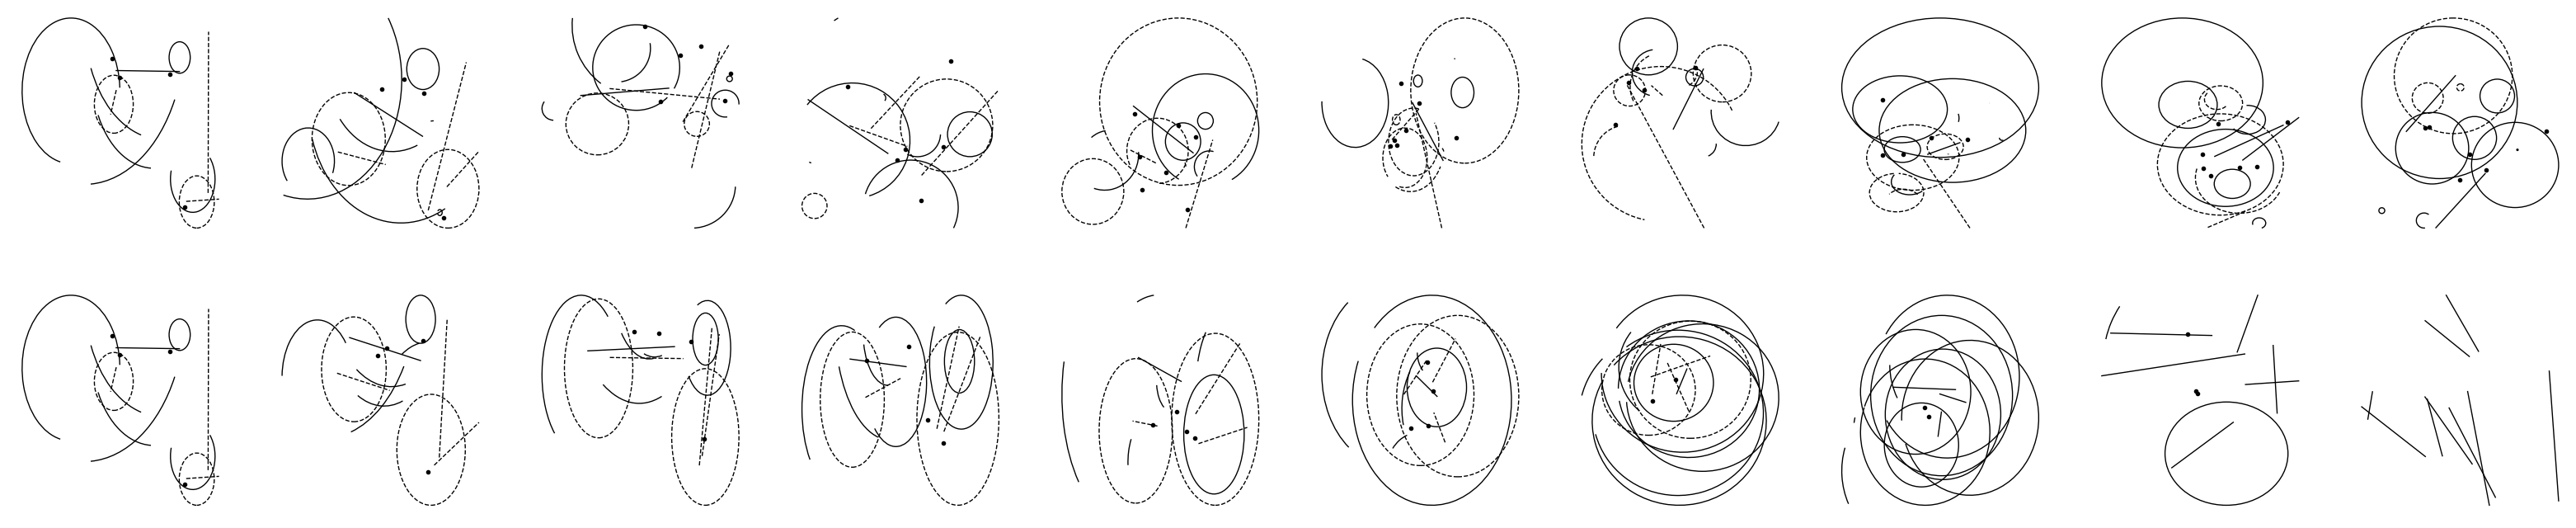

In [31]:
fig, axes = plt.subplots(nrows = 2, ncols = 10, figsize=(40, 8))
seed = model.noise_scheduler.sample_latent(1)
sample = model.denoise(seed, axes)
plt.show(fig)
plt.close(fig)

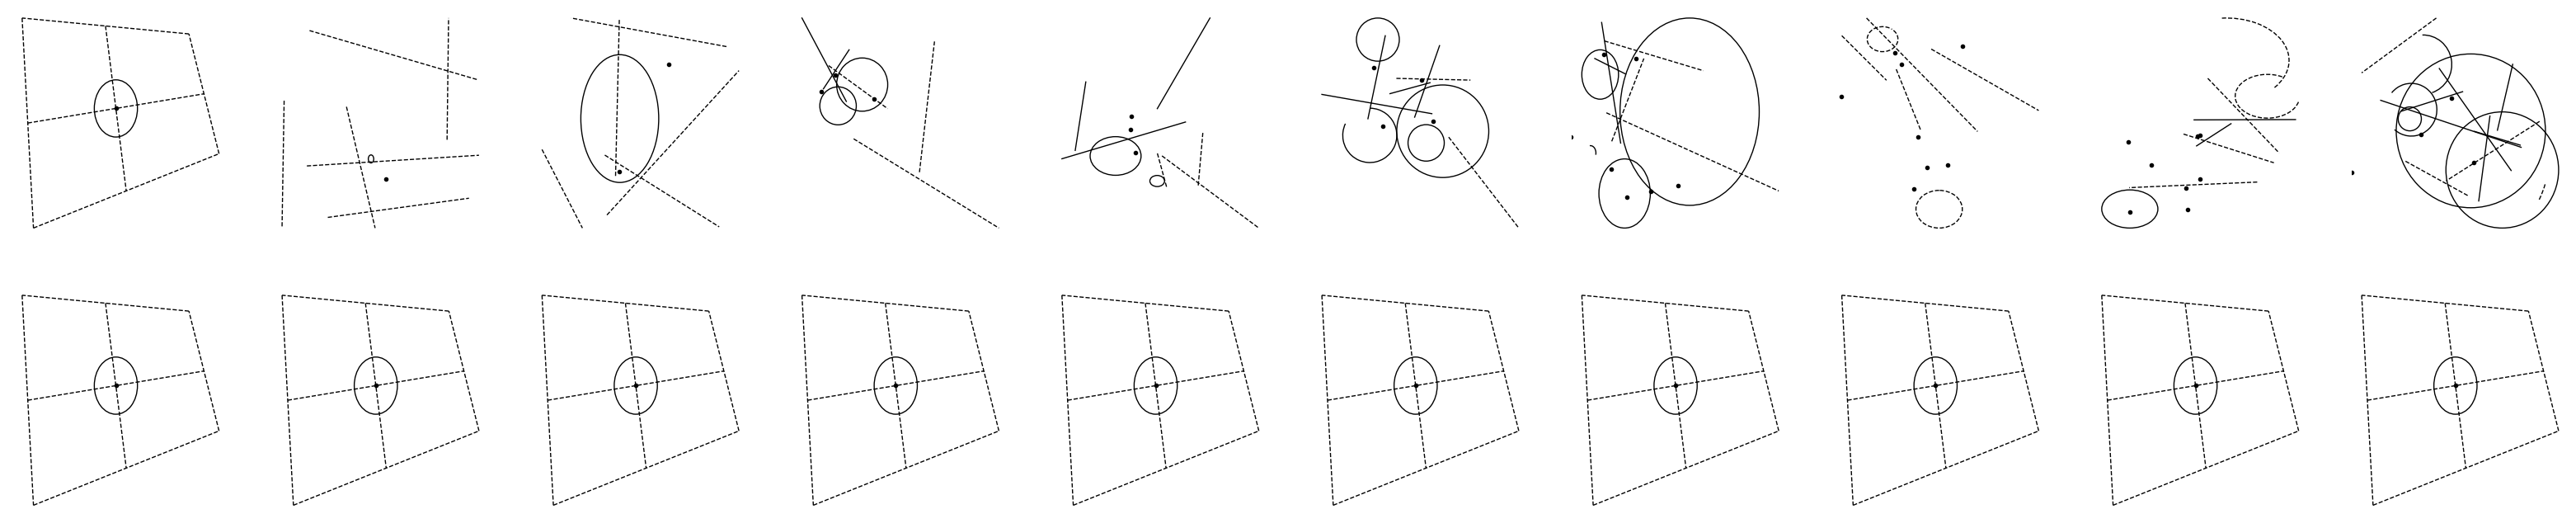

In [ ]:
# model.eval()
# fig, axes = plt.subplots(nrows = 2, ncols = 10, figsize=(40, 8))
# seed = model.noise_scheduler.sample_latent(1)
# sample = model.denoise(seed, axes, ground = nodes[None,0].to(gpu_id))
# plt.show(fig)
# plt.close(fig)

In [ ]:
# model.eval()
# scheduler = CosineNoiseScheduler(1000, gpu_id)
# x = nodes[None,0].to(gpu_id)
# t = 400
# noisy, noise = scheduler(x, t)

# SketchDataset.render_graph(x[...,1:].squeeze(0).cpu(), torch.zeros(size = (24, 24, 17)).cpu())
# SketchDataset.render_graph(noisy[...,1:].squeeze(0).cpu(), torch.zeros(size = (24, 24, 17)).cpu())
# timestep = torch.tensor([t], dtype = torch.int32, device = gpu_id)
# print(timestep.shape)
# pred = x.clone()
# next = model.reverse(x, noisy, t)

# SketchDataset.render_graph(next[...,1:].squeeze(0).cpu(), torch.zeros(size = (24, 24, 17)).cpu())
# print("")

In [ ]:
# nodes = model.noise_scheduler.sample_latent(1)
# nodes = nodes.to(gpu_id)

# # SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu())
# num_images = 10
# j = num_images - 1
# fig, axes = plt.subplots(nrows = 1, ncols = num_images, figsize=(40, 4))
# stepsize = int(model.max_timestep/num_images)
    
# for t in reversed(range(1, model.max_timestep)):
#     # model expects a timestep for each batch
#     batch_size = nodes.size(0)
#     time = torch.Tensor([t]).expand(1).int().to(gpu_id)
#     pred_noise = model.forward(nodes, time)
#     denoised_nodes = model.get_pred(pred_noise, nodes, t)
#     nodes = model.reverse(denoised_nodes, nodes, t)

#     if t % stepsize == 0:
#         SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[j])
#         # SketchDataset.render_graph(denoised_nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[1, j])
#         j = j - 1
    
# SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[0])
# # SketchDataset.render_graph(denoised_nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[1, 0])
# plt.show(fig)
# plt.close(fig)

In [ ]:
# model.eval()
# fig, axes = plt.subplots(nrows = 2, ncols = 10, figsize=(40, 8))
# seed = model.noise_scheduler.sample_latent(1)
# sample = model.denoise(seed, axes)
# plt.show(fig)
# plt.close(fig)

In [ ]:
# gpu_id = 0
# D = 9
# x0 = torch.eye(n = 1, m = D, device = gpu_id).unsqueeze(0)
# noise_scheduler = CosineNoiseScheduler(1000, device = gpu_id)
# t = torch.arange(0, 1, 1 / (1000 + 1), device = gpu_id)

# alpha = torch.zeros(1000, device = gpu_id)

# for i in range(1000):
#     x = x0.expand(10000, -1, -1)

#     latent, _ = noise_scheduler.apply_discrete_noise(x, i)

#     y = F.one_hot(torch.argmax(latent, dim = -1), D).float().mean(0).squeeze()

#     alpha[i] = y[0]

# plt.plot(t[1:].cpu(), alpha.cpu())
# plt.axhline(y=1/D, color='g', linestyle=':', label='1/D')
# plt.axhline(y=0, color='r', linestyle=':', label='0')
# plt.legend()

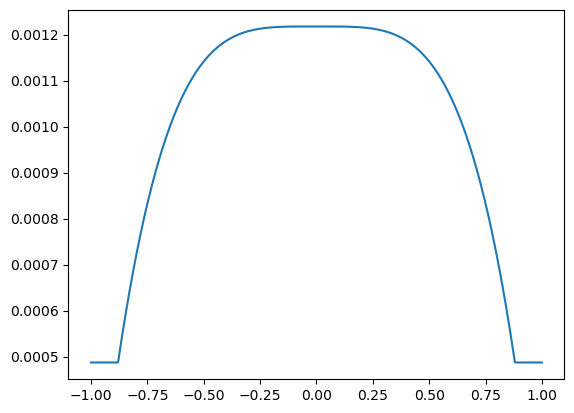

In [7]:
p = (1 - torch.linspace(-1, 1, 999) ** 4).clamp(2/5)
p = p / p.sum()
plt.plot(torch.linspace(-1, 1, 999), p)